# CS 555: Homework 2
### Eric Stevens
### October 18, 2018

In this project, a finite state transducer is constructed to take three one, two, and three digit integers and turn them into strings that spell out the number. The methodology used to construct the FST is modular in nature. In the first section, the basic building blocks are created. The second stage involves connecting the building blocks in various ways in order to acomplish specific tasks. Finally a union is performed that all possible tasks to be acomplished from a single input.

In [4]:
from __future__ import print_function
from __future__ import unicode_literals
import pynini
import re
from string import punctuation, ascii_letters

## The Basic Blocks
Here, the smallest units are built as single input transducers. The `pynini.stringmap()` function takes nested lists and converts them into FSTs. These blocks will be used in later sections to acomplish the goals of the final task.

In [5]:
# Construct string maps for each building block.
# These building blocks will be used to construct
# everything the FST needs to do.

# maps 0 to "zero"
T0 = pynini.string_map([["0","[zero]"]])

# maps 0 to no output
T0E = pynini.string_map([["0","[<epsilon>]"]])

# maps all single digit numbers other than 0 to string form
T1 = pynini.string_map([["1","[one]"],
                       ["2","[two]"],
                       ["3","[three]"],
                       ["4","[four]"],
                       ["5","[five]"],
                       ["6","[six]"],
                       ["7","[seven]"],
                       ["8","[eight]"],
                       ["9","[nine]"]
                       ])

# maps teen integers to string form
T10 = pynini.string_map([["0","[ten]"],
                       ["1","[eleven]"],
                       ["2","[twelve]"],
                       ["3","[thirteen]"],
                       ["4","[fourteen]"],
                       ["5","[fifteen]"],
                       ["6","[sixteen]"],
                       ["7","[seventeen]"],
                       ["8","[eighteen]"],
                       ["9","[nineteen]"]
                       ])

# maps two digit ints 20 and above to string form
T29 = pynini.string_map([["0","[<epsilon>]"],
                       ["2","[twenty]"],
                       ["3","[thirty]"],
                       ["4","[forty]"],
                       ["5","[fifty]"],
                       ["6","[sixty]"],
                       ["7","[seventy]"],
                       ["8","[eighty]"],
                       ["9","[ninety]"]
                       ])


# maps no input to "hundred"
T100 = pynini.string_map([["[<epsilon>]","[hundred]"]])


## Assembling Blocks to Acomplish Specific Tasks
Here, the basic building blocks are tied to gether, in either series (`concat()`) or parallel (`union()`) in order to acomplish specific goals. These goals are the following:

* **X_0_9:** Converts single digits to word form.
* **X_teens:** Converts numbers 10 through 19 to word form.
* **X_20_99:** Converts numbers 20 through 99 to word form.
* **X_100:** Converts numbers 100 through 999 to word from.

This process can be thought of as building 1, 2, and 3 digit transducers that can be tied together to complete the system.

In [6]:
# Build FST for single digits

X_0_9 = pynini.union(T0,T1).rmepsilon()


In [7]:
# Build FST for numbers 10 to 19

X_teens = pynini.concat(pynini.string_map([["1","[<epsilon>]"]]), T10).rmepsilon()


In [8]:
# Build FST for numbers 20 to 99

X_0E = pynini.union(T1,T0E).rmepsilon()
X_20_99 = pynini.concat(T29,X_0E).minimize().rmepsilon()


In [9]:
# Build FST for number 100 to 999

X_TH = pynini.concat(T1,T100)
X_10_99 = pynini.union(X_teens, X_20_99)
X_100 = pynini.concat(X_TH,X_10_99).minimize().rmepsilon()


## Build the System

This final section just puts all of task blocks in parallel. Since we have 1, 2, and 3 digit task blocks, combining them in parallel (`union()`) will not cause an issue as the final states of each of the task blocks can only be reached by a digit of the proper size.

In [10]:
# Combine into cohesive system

F_19 = pynini.union(X_0_9, X_teens)
F_99 = pynini.union(F_19, X_20_99)
F_999 = pynini.union(F_99,X_100).rmepsilon()


## Leading Zeros Afterthought
Finally an arc is added to deal with the very special case. This arc is added to deal with cases like `003` and `030`. By looping a `0:<epsilon>` on the initial stat we effectivly trim the input to its first non-zero digit. This completes the graph, seen below.

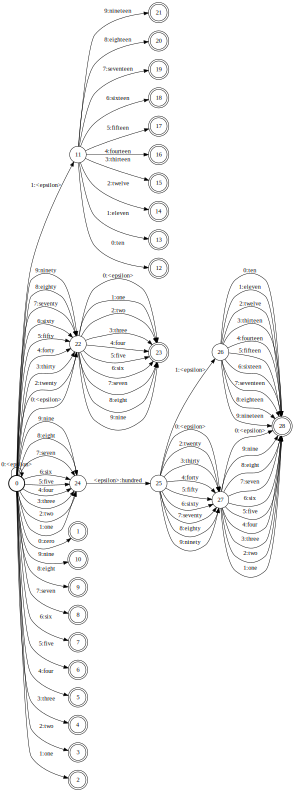

In [11]:
# Accept cases that begin with zeros
F_999.add_arc(0,pynini.Arc(F_999.input_symbols().find('0'),F_999.input_symbols().find('<epsilon>'),0,0))

From close inspection of the graph above we can see the modular nature of it. Single digits will immediately reach terminal state at the bottom of the graph. Two digit numbers will move to the top of the graph and cascade through it. Three digit numbers will pass through the middle block and have a `hundred` inserted between the third and second digit. Finally, leading zeros will be looped on the initial state being replaced with `<epsilon>` until another number is reached at which point it will be treated as the a regular number.

## Compose Function
This function is a utility to make it easy to run the FST on an input. It will accept either integer or string input and return a string of the ouput. After the function defintion, we call the function on every digit in the range to insure proper output.

In [13]:
# Function for calculation 
def int_to_word3(in_int):
    return pynini.compose(str(in_int),F_999).stringify(F_999.output_symbols())


In [14]:
# Loop entire range
for x in range(1000):
    print(int_to_word3(x))

zero
one
two
three
four
five
six
seven
eight
nine
<epsilon> ten
<epsilon> eleven
<epsilon> twelve
<epsilon> thirteen
<epsilon> fourteen
<epsilon> fifteen
<epsilon> sixteen
<epsilon> seventeen
<epsilon> eighteen
<epsilon> nineteen
twenty <epsilon>
twenty one
twenty two
twenty three
twenty four
twenty five
twenty six
twenty seven
twenty eight
twenty nine
thirty <epsilon>
thirty one
thirty two
thirty three
thirty four
thirty five
thirty six
thirty seven
thirty eight
thirty nine
forty <epsilon>
forty one
forty two
forty three
forty four
forty five
forty six
forty seven
forty eight
forty nine
fifty <epsilon>
fifty one
fifty two
fifty three
fifty four
fifty five
fifty six
fifty seven
fifty eight
fifty nine
sixty <epsilon>
sixty one
sixty two
sixty three
sixty four
sixty five
sixty six
sixty seven
sixty eight
sixty nine
seventy <epsilon>
seventy one
seventy two
seventy three
seventy four
seventy five
seventy six
seventy seven
seventy eight
seventy nine
eighty <epsilon>
eighty one
eighty two
e

six hundred twenty three
six hundred twenty four
six hundred twenty five
six hundred twenty six
six hundred twenty seven
six hundred twenty eight
six hundred twenty nine
six hundred thirty <epsilon>
six hundred thirty one
six hundred thirty two
six hundred thirty three
six hundred thirty four
six hundred thirty five
six hundred thirty six
six hundred thirty seven
six hundred thirty eight
six hundred thirty nine
six hundred forty <epsilon>
six hundred forty one
six hundred forty two
six hundred forty three
six hundred forty four
six hundred forty five
six hundred forty six
six hundred forty seven
six hundred forty eight
six hundred forty nine
six hundred fifty <epsilon>
six hundred fifty one
six hundred fifty two
six hundred fifty three
six hundred fifty four
six hundred fifty five
six hundred fifty six
six hundred fifty seven
six hundred fifty eight
six hundred fifty nine
six hundred sixty <epsilon>
six hundred sixty one
six hundred sixty two
six hundred sixty three
six hundred sixty f

<span style="color:red">Self Comments:</span>

The solution is correct.